# Apply NSW DOI Water validation mask and examine the populations of pixels inside and outside the polygons

**What does this notebook do?**

This notebook produces histograms of the populations of pixel inside and outside of the Namoi irrigated crop area polygons provided by NSW DOI Water. It also produces a scatter plot comparing NDVI against NDMI for each pixel within the Namoi Catchment study area to explore whether there is a relationship between these two indices for irrigated vs non-irrigated pixels.

This notebook is used to determine a suitable threshold value for the automatic irrigated crop product.

**Required inputs**
* NDVI and NDMI geotiffs
* Validation mask for irrigated vs non-irrigated crop areas, as a .pkl file

**Date** May 2018

**Author** Claire Krause

In [1]:
%pylab notebook

import xarray as xr
import glob
import pickle

Populating the interactive namespace from numpy and matplotlib


## Set up the notebook

In [2]:
year = '2013'
Index = 'NDVI'

In [3]:
maskFile = 'NSWDOIwaterMask_{0}.pkl'.format(year)

In [4]:
NDVIFile = '/g/data/r78/cek156/datacube_stats/Namoi_summer/NDVI/withls7/ndvi_None_{0}*.tif'.format(int(year) - 1)
NDMIFile = '/g/data/r78/cek156/datacube_stats/Namoi_summer/NDMI/withls7/ndmi_None_{0}*.tif'.format(int(year) - 1)

## Load in the max NDVI and NDMI geotiffs

In [5]:
# Open the Geotiff
NDVIData = xr.open_rasterio(glob.glob(NDVIFile)[0])
NDMIData = xr.open_rasterio(glob.glob(NDMIFile)[0])

In [6]:
# Grab just the band 3 (max) data
NDVIDatamax = NDVIData.sel(band = 3)
NDMIDatamax = NDMIData.sel(band = 3)

In [7]:
# Make sure all the missing values are taken out
NDVIDatamaxNonull = NDVIDatamax.where(NDVIDatamax != -1)
NDMIDatamaxNonull = NDMIDatamax.where(NDMIDatamax != -1)

## Read in the validation mask and use it to examine the resulting pixel populations

In [8]:
# Open the pickled mask
with open(maskFile, 'rb') as f:
    mask = pickle.load(f)

In [9]:
# Data * mask = data or nan
NDVIIrrigated = mask * NDVIDatamaxNonull
# Find where the mask is nan, and use this True/False to mask data
NDVINonIrrigated = NDVIDatamaxNonull.where(np.isnan(mask))

# Data * mask = data or nan
NDMIIrrigated = mask * NDMIDatamaxNonull
# Find where the mask is nan, and use this True/False to mask data
NDMINonIrrigated = NDMIDatamaxNonull.where(np.isnan(mask))

## Need to flatten the data so we can plot two single dimension arrays against each other

In [10]:
NDVIIrrigatedflat = NDVIIrrigated.data.reshape(NDVIIrrigated.x.size * NDVIIrrigated.y.size)
NDVINonIrrigatedflat = NDVINonIrrigated.data.reshape(NDVINonIrrigated.x.size * NDVINonIrrigated.y.size)

NDMIIrrigatedflat = NDMIIrrigated.data.reshape(NDMIIrrigated.x.size * NDMIIrrigated.y.size)
NDMINonIrrigatedflat = NDMINonIrrigated.data.reshape(NDMINonIrrigated.x.size * NDMINonIrrigated.y.size)

## Draw a histogram of the two populations

Matplotlib histogram doesn't like `nan`, so we need to remove the `nan` values before we can create a histogram. This is done by reshaping the array into a single dimension, then removing the nan values.

This histogram will allow us to determine a valid threshold value for the automatic irrigated crop extent layer.

<IPython.core.display.Javascript object>


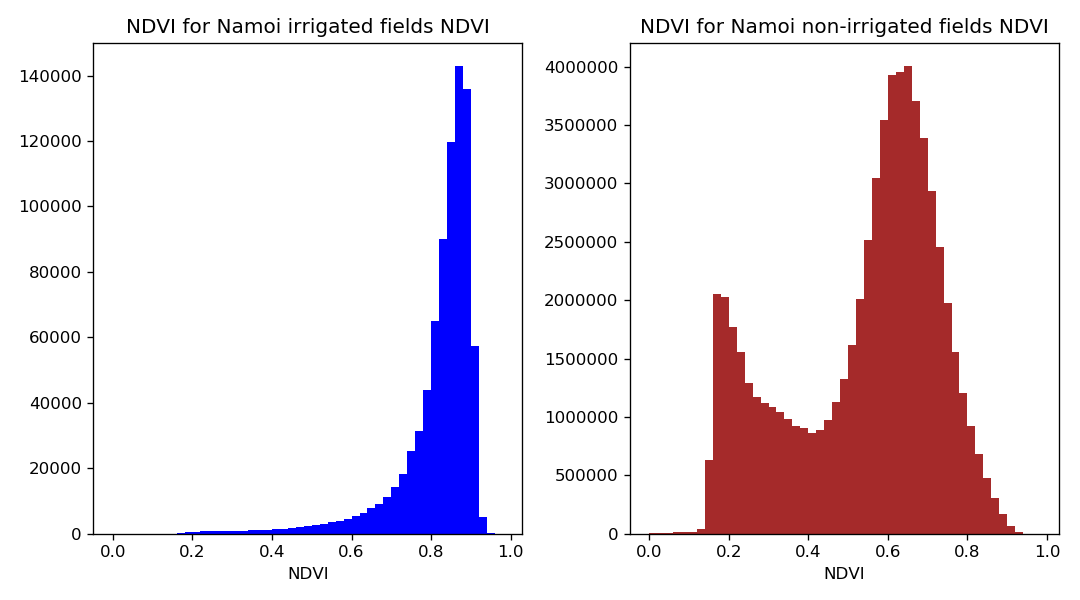

In [11]:
bin_values = np.arange(0, 1.0, 0.02)

fig, axs = plt.subplots(1, 2, sharex=True, tight_layout=True, figsize = [9,5])
axs[0].hist(NDVIIrrigatedflat[np.isfinite(NDVIIrrigatedflat)], bins=bin_values, facecolor = 'blue');
axs[0].set_title('{0} for Namoi irrigated fields {0}'.format(Index, year))
axs[0].set_xlabel(Index)
axs[1].hist(NDVINonIrrigatedflat[np.isfinite(NDVINonIrrigatedflat)], bins=bin_values, facecolor = 'brown');
axs[1].set_title('{0} for Namoi non-irrigated fields {0}'.format(Index, year))
axs[1].set_xlabel(Index)
savefig('/g/data/r78/cek156/dea-notebooks/Crop_mapping/Playing_around/Namoi_NDVI_{1}.jpg'.format(Index, year))

## Is there a relationship between a pixel's NDVI and NDMI?

<IPython.core.display.Javascript object>


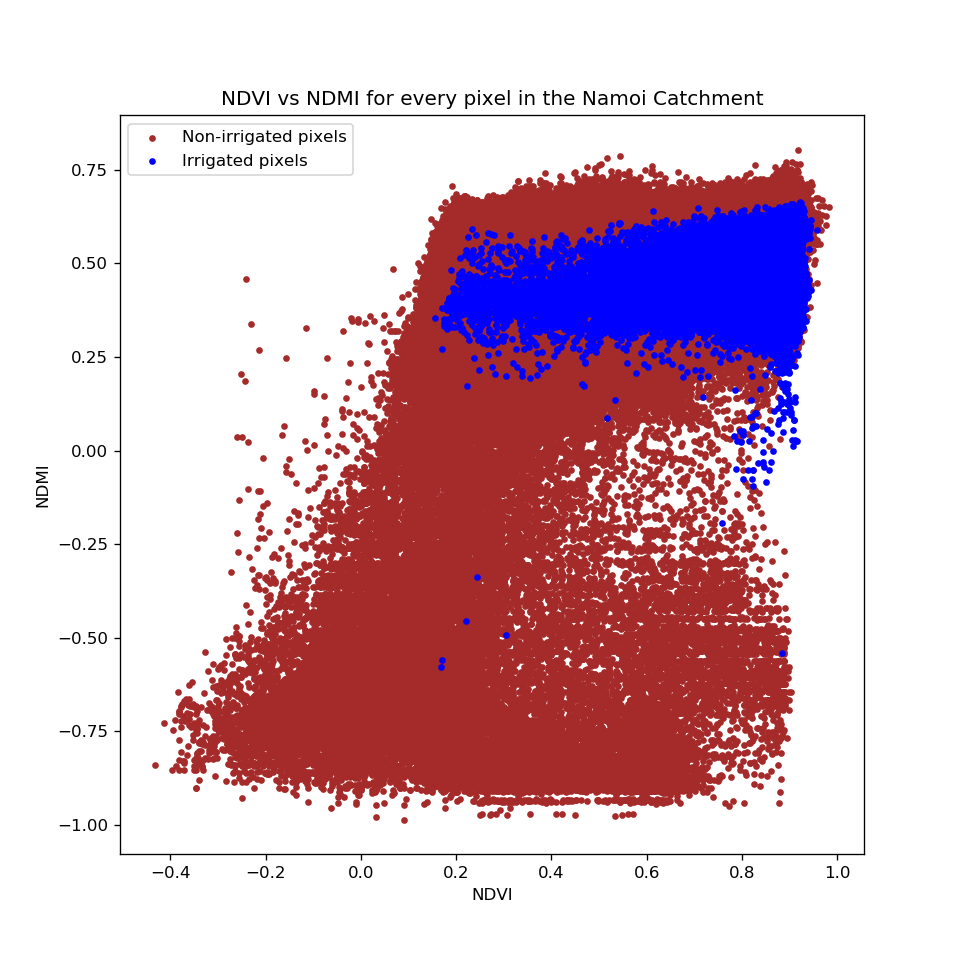

In [12]:
plt.figure(figsize = [8,8])

plt.scatter(NDVINonIrrigatedflat[::10], NDMINonIrrigatedflat[::10], facecolor = 'brown', marker = '.')
plt.scatter(NDVIIrrigatedflat[::10], NDMIIrrigatedflat[::10], facecolor = 'blue', marker = '.')
plt.xlabel('NDVI')
plt.ylabel('NDMI')
plt.title('NDVI vs NDMI for every pixel in the Namoi Catchment')
plt.legend(['Non-irrigated pixels', 'Irrigated pixels'])
savefig('/g/data/r78/cek156/dea-notebooks/Crop_mapping/Playing_around/Namoi_scatter_{0}.jpg'.format(year))